In [6]:
from numpy import pi,sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

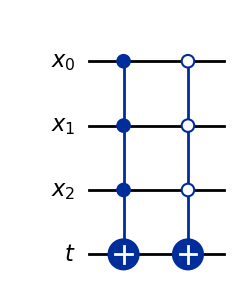

In [15]:
def bingo_detector():
    rx = QuantumRegister(3, 'x')
    rt = QuantumRegister(1, 't')
    qc = QuantumCircuit(rx, rt)

    qc.mcx(rx, rt, ctrl_state='111')

    qc.mcx(rx, rt, ctrl_state='000')

    return qc

qc = bingo_detector()
qc.draw('mpl', plot_barriers=False)

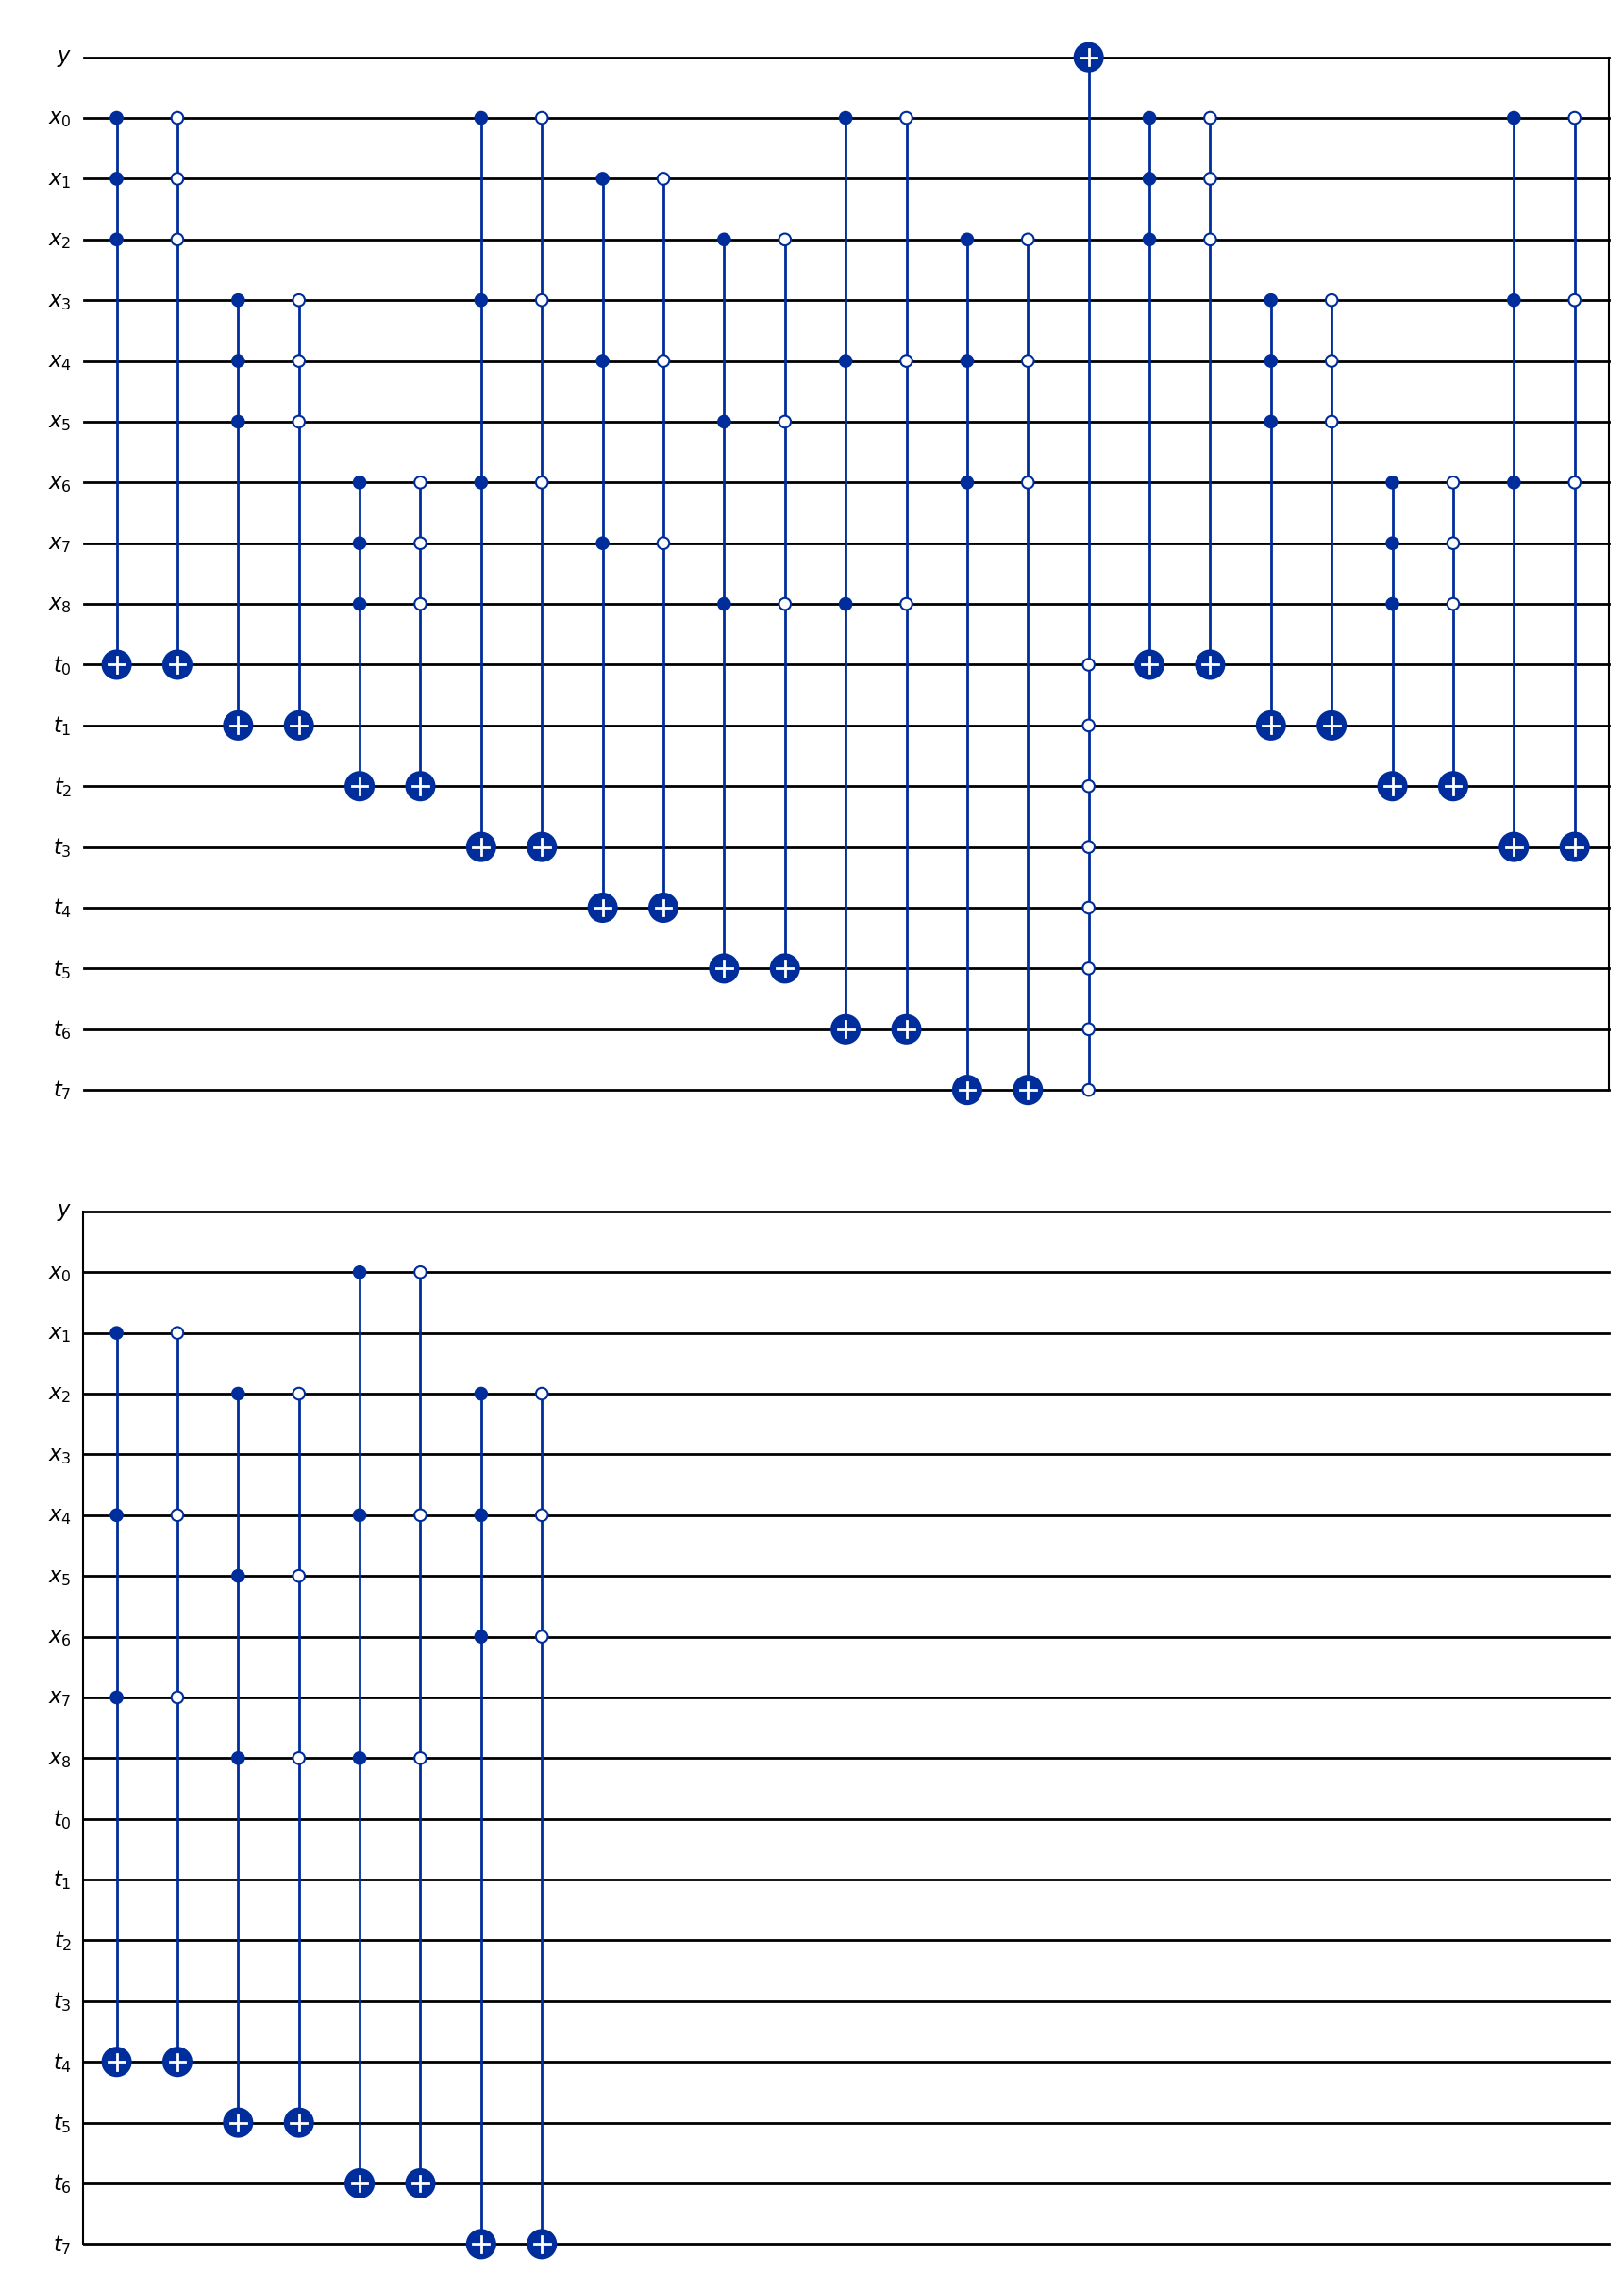

In [17]:
# 틱택토

def tictactoe():
    ry = QuantumRegister(1, 'y')
    rx = QuantumRegister(9, 'x')
    rt = QuantumRegister(8, 't')
    qc = QuantumCircuit(ry, rx, rt)

    idx = 0
    for i in range(0, 7, 3):
        qc.compose(bingo_detector(), [rx[i],rx[i+1],rx[i+2],rt[idx]], inplace=True)
        qc.barrier()
        idx += 1

    for i in range(0, 3, 1):
        qc.compose(bingo_detector(), [rx[i],rx[i+3],rx[i+6],rt[idx]], inplace=True)
        qc.barrier()
        idx += 1

    qc.compose(bingo_detector(), [rx[0],rx[4],rx[8],rt[idx]], inplace=True)
    qc.barrier()
    idx += 1

    qc.compose(bingo_detector(), [rx[2],rx[4],rx[6],rt[idx]], inplace=True)

    qc.barrier()
    qc.mcx(rt, ry, ctrl_state='00000000')
    qc.barrier()
    
    idx = 0
    for i in range(0, 7, 3):
        qc.compose(bingo_detector(), [rx[i],rx[i+1],rx[i+2],rt[idx]], inplace=True)
        qc.barrier()
        idx += 1

    for i in range(0, 3, 1):
        qc.compose(bingo_detector(), [rx[i],rx[i+3],rx[i+6],rt[idx]], inplace=True)
        qc.barrier()
        idx += 1

    qc.compose(bingo_detector(), [rx[0],rx[4],rx[8],rt[idx]], inplace=True)
    qc.barrier()
    idx += 1

    qc.compose(bingo_detector(), [rx[2],rx[4],rx[6],rt[idx]], inplace=True)
    qc.barrier()
    return qc

qc = tictactoe()
qc.draw('mpl', plot_barriers=False)

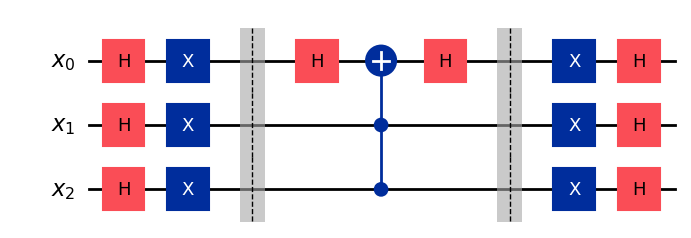

In [9]:
# diffusion circuit for n qubits
def diffuser_circuit(n):
    x = QuantumRegister(n,'x')
    qc = QuantumCircuit(x) # n 큐비트 회로 객체 생성
    qc.h(x)                # 모든 큐비트에 H
    qc.x(x)                # 모든 큐비트에 X

    qc.barrier()
    qc.h(x[0])             # x0 (target 큐비트) 에만 H
    qc.mcx(x[1:n], x[0])   # 제어 큐비트 x[1,2,...,n-1], 타겟 큐비트 x[0] 인 다중제어 X gate
    qc.h(x[0])             # x0 (target 큐비트) 에만 H
    qc.barrier()           # HXH=Z 이기 때문에 이 결과는 다중제어-Z gate 와 같다.

    qc.x(x)                # 모든 큐비트에 X
    qc.h(x)                # 모든 큐비트에 H

    qc.name = "Diffuser"
    return qc

circuit = diffuser_circuit(3) # 함수를 호출하여 회로를 표현하는 객체를 생성
circuit.draw(output='mpl') # circuit 회로를 matplot library 형식의 그림 화일로 출력


In [10]:
hole = [1, 2, 3, 5, 6, 7, 8]

rep=3


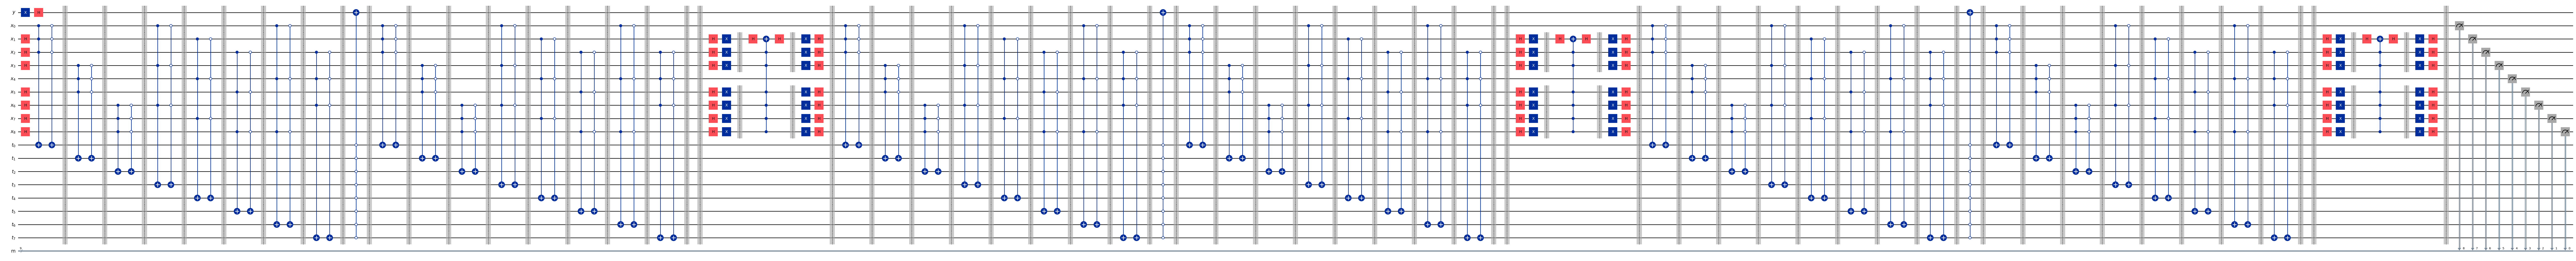

In [18]:
M = 7
n = len(hole)
rep = int(pi*sqrt((2**n)/M)/4)
print(f"rep={rep}")
ry = QuantumRegister(1, 'y')
rx = QuantumRegister(9, 'x')
rt = QuantumRegister(8, 't')
rm = ClassicalRegister(9,'m')
circuit = QuantumCircuit(ry, rx, rt, rm)

circuit.x(ry)
circuit.h(ry)

for i in hole:
    circuit.h(rx[i])

for _ in range (rep):
    circuit.compose(tictactoe(), ry[:]+rx[:]+rt[:], inplace=True)
    circuit.barrier()
# diffuser_circuit() 을 호출하여 디퓨저 회로를 circuit 에 추가
    circuit.compose(diffuser_circuit(len(hole)), [rx[i] for i in hole], inplace=True)
    circuit.barrier()

circuit.measure(rx,reversed(rm))              # qx 레지스터의 모든 큐비트들을 측정하여 c 레지스터로 읽는 회로를 구현
circuit.draw(fold=-1,output='mpl') # circuit 회로를 matplot library 형식의 그림 화일로 출력

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_circuit = pm.run(circuit)
sampler = Sampler(mode=aer_sim)
job = sampler.run([isa_circuit], shots=1000)
result = job.result()
count = result[0].data.m.get_counts()
print(count)

{'010001101': 148, '011100101': 127, '010101101': 144, '001100011': 150, '011100011': 150, '010100101': 131, '011100001': 141, '000101111': 1, '000101001': 1, '011001110': 1, '001001001': 1, '011101101': 1, '001101111': 1, '010001010': 1, '011101000': 1, '000001001': 1}


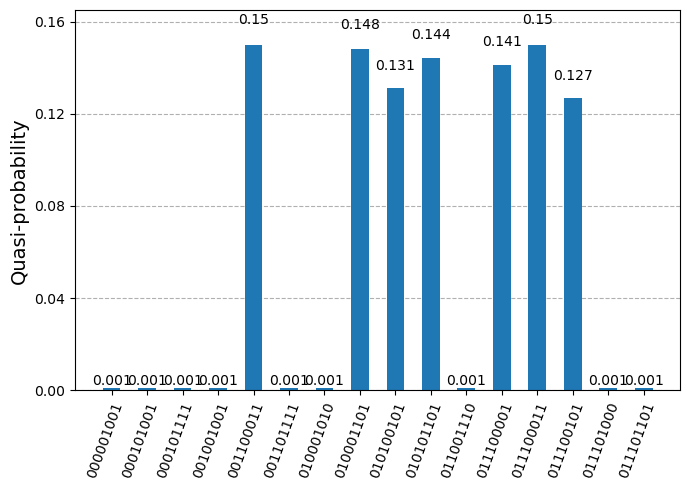

In [13]:
from qiskit.visualization import plot_distribution
plot_distribution(count)

In [14]:
keys = list(count.keys())
print(keys)

result = sorted([k for k, v in count.items() if v > 30])
print(result)
# 1: x 0 : o
encoding = {'0' : 'O', '1' : 'X'}
valid_keys = []
for key in result:
    print('---------------')
    for i, e in enumerate(key):
        text = encoding[e]
        print(f'| {text} |', end='')
        if i%3 == 2:
            print()
    print('---------------')
    valid_keys.append(key)
    

['010001101', '011100101', '010101101', '001100011', '011100011', '010100101', '011100001', '000101111', '000101001', '011001110', '001001001', '011101101', '001101111', '010001010', '011101000', '000001001']
['001100011', '010001101', '010100101', '010101101', '011100001', '011100011', '011100101']
---------------
| O || O || X |
| X || O || O |
| O || X || X |
---------------
---------------
| O || X || O |
| O || O || X |
| X || O || X |
---------------
---------------
| O || X || O |
| X || O || O |
| X || O || X |
---------------
---------------
| O || X || O |
| X || O || X |
| X || O || X |
---------------
---------------
| O || X || X |
| X || O || O |
| O || O || X |
---------------
---------------
| O || X || X |
| X || O || O |
| O || X || X |
---------------
---------------
| O || X || X |
| X || O || O |
| X || O || X |
---------------
